# Linear Regression
Regression is an approach to finding function $f(x)$, that models the conditional expectation of $Y$ given X:

$$
f(x) = E[Y|X=x]
$$

In linear regression, we assume that this function is globally linear (see [parent README.md](../README.md) for the meaning of this.).

In regression, minimizing the sum of square residuals by finding the the minimizing set of parameters is called the least squared solution,
and the regression function when viewed in a statistical sense is the solution to least squares.

For linear regression,there is an analytical solution derived from linear algebra:
$$
\hat{\vec{b}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T*\vec{y}
$$

Alternatively, when direct matrix inversion is computationally prohibitive (due to its cubic complexity in the number of features, O(p³)), iterative methods like (mini-)batch gradient descent are preferred (O(np) per iteration). 

While the analytical solution, in its purest form, requires a global computation on the entire dataset, making it difficult to directly parallelize in the same way as gradient descent is and the tool ecosystem is very mature for optimizing in this way.


$$
Loss = (\vec{y} - \mathbf{X}\vec{b})^T(\vec{y} - \mathbf{X}\vec{b}) \\
\forall (\forall \mathbf{X}_{b} \in \mathbf{X}) \in N_{trainiter} \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M *\nabla_{\hat{\vec{b}}} Loss \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M * 2\mathbf{X}_b^T*(\vec{y} - \mathbf{X}_b \hat{\vec{b}})
$$

## Assumptions:
* Can have additive error, $ y = f(x) + \epsilon $, and uncorrelated with x ( $\epsilon \perp X$) constant variance and usually $\epsilon  \sim N(0,\sigma^2)$. This helps for further statistical analysis.
* Globally linear f(x)

## Example:
Lets generate some data using a linear model with additive error, and use both the gradient based and analytical model to see if we can get the original parameters.


In [1]:
import numpy as np

coefficients = np.array([0.1, 5]).T
bias = np.array([3])

noise = np.random.normal(0, 1, (1000))

input = np.random.uniform(-1.0, 1.0, (1000, 2))

output = noise + input @ coefficients + bias

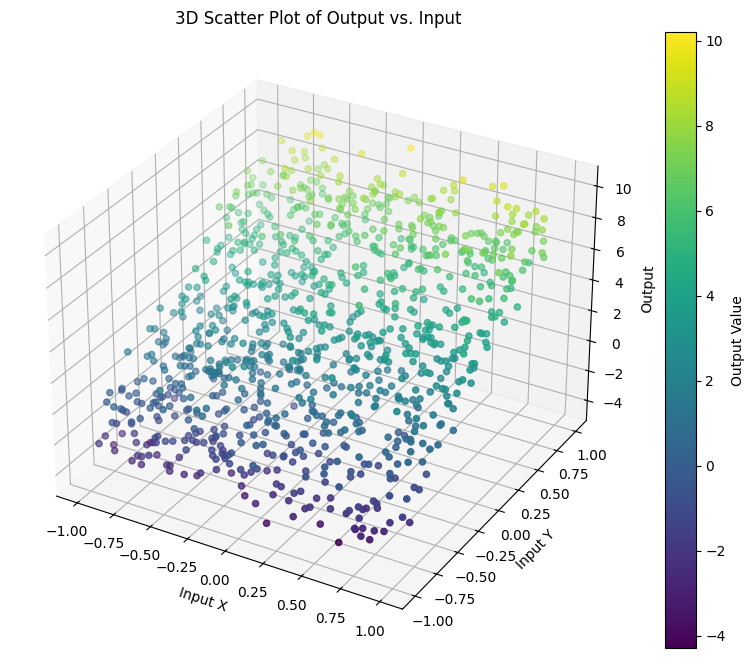

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(input[:, 0], input[:, 1], output, c=output, cmap='viridis', marker='o')
ax.set_xlabel("Input X")
ax.set_ylabel("Input Y")
ax.set_zlabel("Output")
ax.set_title("3D Scatter Plot of Output vs. Input")
fig.colorbar(scatter, label="Output Value")
plt.show()

In [5]:
# analytical approach:
inputWithBias = np.hstack([input, np.ones((input.shape[0], 1))])
coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
print(f"Estimated coefficients: {coefficientsEstimateAnalytical[:-1]}, true coefficients: {coefficients}")
print(f"Estimated bias: {coefficientsEstimateAnalytical[-1]}, true bias: {bias}")
mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
print(f"mse: {mse}")

Estimated coefficients: [0.09444258 5.00233389], true coefficients: [0.1 5. ]
Estimated bias: 2.9970554262438496, true bias: [3]
mse: 1.015782440691674


In [6]:
# gradient based approach:
coefficientsEstimateGradient = np.random.normal(0, 1, (3))
batchSize = 10
learningRate = 0.01
epochs = 10
for epoch in range(epochs):
    for batch in range(inputWithBias.shape[0] // batchSize):
        batchInput = inputWithBias[batchSize * batch : batchSize * batch + batchSize]
        batchOutput = output[batchSize * batch : batchSize * batch + batchSize]
        coefficientsEstimateGradient += learningRate * 1 / batchInput.shape[0] * 2 * batchInput.T @ (batchOutput - batchInput @ coefficientsEstimateGradient)
    epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
    print(f"end epoch {epoch + 1}, mse: {epochalMSE}")

end epoch 1, mse: 4.64925496898435
end epoch 2, mse: 1.9408991210896007
end epoch 3, mse: 1.2618420751744204
end epoch 4, mse: 1.0818003731189998
end epoch 5, mse: 1.0337244503495735
end epoch 6, mse: 1.0208183144911878
end epoch 7, mse: 1.0173293845306466
end epoch 8, mse: 1.0163762968835097
end epoch 9, mse: 1.0161113449350694
end epoch 10, mse: 1.0160353862251308


In [7]:
coefficientsEstimateGradient, coefficientsEstimateAnalytical

(array([0.10404711, 4.99373553, 2.98313888]),
 array([0.09444258, 5.00233389, 2.99705543]))

This shows they get to the same place.

## Goodness of fit
The goal of goodness-of-fit tests in linear regression is to assess how well the model's assumptions hold and whether the model adequately captures the relationship between the predictors and the response. This goes beyond just minimizing the loss function; it's about ensuring the validity of the model and its interpretations.

The fundamental approach is to use a model output ($\hat{\vec{y}}$) vs residual ($\hat{\vec{y}} - \vec{y}$) plot, this is expected to be a random scatter centered around 0.

If it's not (e.g., a curved pattern or a non-constant variance (not Homoscedasticity)) one can dig further to see which features are non linear by considering feature vs residual plot. 

One could then try to transform the feature/output to have a more linear relationship, or consider another model.


### For interpretability
It's important for interpretability and to make inferences about coefficients to look at and check for multi-colinearity and to look at and check for normality of errors.

#### Multi - collinearity
This violates one of the assumptions that each feature is independent from another $P(X_i | X_j) = P(X_i), \forall i, j$ where $i \neq j$.

Two approaches:

##### VIF
VIF is the Variance Inflation Factor (VIF). It is performing linear regression treating the feature for which you are finding the VIF for as dependent varaible to be predicted by all the other features, then computing $ 1 / (1 - R^2)$ for this model. $R^2$ is 1 - sum of square residuals / total sum of squares, it compares how off we are from predicting the feature over a baseline of just using the average, where 1 means the model is 0 error, than just predicting and 0 means the model explains none of the variance in the VIF feature; it's no better than simply predicting the mean, then The VIF is the reciprocal of (1 - R²), which quantifies how well the model could get on without the feature (since it could be linearly constructed from the others). R² larger is smallest error, so then 1 - R² flips this and reciprical flips it again and R² then larger is smaller error, which would mean that the feature is redundant.

We compute VIFs for each feature and A VIF > 5 (or 10, depending on the context) suggests problematic multicollinearity.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

After you find features with VIFs, you can look at correlation matrix to find the variables that you can consider dropping then recheck for VIF values. You don't necessarily have to do this for just prediction usage but for interpretability of the coefficients. You could also combine them (average or otherwise), or even use regularization thoguh these make interpertability more tricky.

#### Correlation matrix
One could also directly examine the correlation matrix of the predictors. The correlation matrix is derived from covariance matrix, its the covariance matrix divided by the product of the standard deviations of the two variables in each pair- it normalizes the covariance so its always between -1 and 1, removing the scaling differences that would otherwise make covariance a good option to compare how features "move together" which is the condition of multi collinearity that we seek.



Look for high pairwise correlations (e.g., |r| > 0.8 or 0.9).


(tk: categorical vars), then do with toy.

In [1]:

## Interpretability
(tk)
(p values)

## Validation
(tk, when comparing with other models, test set etc)

## Feature Notes
(tk)
(F statistic for selection, VIF again for selection)
(tk, maybe gradient descent and normalization/standardization)

## Hyper parameters

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1383534191.py, line 3)